# Vizualise correlations & cell assemblies activity

Load packages

In [ ]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
import copy
import json
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
import sys 
import pickle
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
from scipy import stats
import matplotlib.colors as mcolors
import warnings
from scipy import interpolate
import re
from scipy.stats import f_oneway
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import diptest
import random
from collections import Counter, defaultdict
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

import ast
warnings.filterwarnings("ignore")

#%matplotlib widget

### Correlation across vigilance states

In [ ]:
try: # tries to retrieve dfilepath either from a previous run or from a previous notebook
    %store -r dfilepath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
dfilepath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/"

fc1 = FileChooser(dfilepath,select_default=True, show_only_dirs = False, title = "<b>Load excel or pkl file</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dfilepath
    dfilepath = chooser.selected
    %store dfilepath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

In [ ]:
try :
    combined_df = pd.read_excel(dfilepath, index_col=0 , sheet_name=None)
except:
    with open(dfilepath, 'rb') as pickle_file:
        combined_df = pickle.load(pickle_file)
        
# dfilepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_VigSt_2025-04-17_15_22_48_TEST/Baseline/Cluster0units/L1NDNF_mice_VigSt_PairCorrCa_Cluster0units.xlsx"
everysheat=1
nbplot=int(len(combined_df)/everysheat)
fig, axes = plt.subplots(1, nbplot, figsize=(15, 5))
axes = np.atleast_1d(axes)  # Makes axes indexable even if it's just one
VMAX=1
VMIN=-.2

plotnb=0

for i in np.arange(len(combined_df))[::everysheat]:
    key = list(combined_df)[i]
        
    CaCorrMatrix=combined_df[key]
    df = CaCorrMatrix.apply(pd.to_numeric, errors='coerce')
    ax = sns.heatmap(df, ax=axes[plotnb], square=True, vmin=VMIN , vmax=VMAX , cmap='viridis',
                                    cbar_kws={'shrink': 0.6, 'aspect': 20})
    
    try:
        # Set only the first and last ticks for x and y axes
        # Get the number of ticks
        x_ticks = ax.get_xticks()
        y_ticks = ax.get_yticks()
        ax.set_xticks([x_ticks[0], x_ticks[-1]])
        ax.set_yticks([y_ticks[0], y_ticks[-1]])

        # Optionally, set the labels for these ticks if needed
        ax.set_xticklabels([f'#{int(x_ticks[0])+1}', f'#{int(x_ticks[-1])+1}'],size=6)
        ax.set_yticklabels([f'#{int(y_ticks[0])+1}', f'#{int(y_ticks[-1])+1}'],size=6)
    except: pass

    # Optionally, add labels for the axes if needed
    ax.set_xlabel('Neurons', labelpad=-2,size=8) 
    ax.set_ylabel('Neurons', labelpad=-8,size=8) 
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the font size here
    cbar.set_label('Correlation coefficient (r)', fontsize=8, font='Arial', rotation=-90, labelpad=10)
    ax.xaxis.set_ticks_position('top')  # Move ticks to the top
    ax.xaxis.set_label_position('top')  # Move label to the top
    axes[plotnb].set_title(f'{key} (r={(np.round(np.nanmean(CaCorrMatrix),2))})', fontsize=12)
    plotnb+=1


#plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_3VigSt_{beg}to{fin}s_2heatmap.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.tight_layout()
plt.show()

### Cell assemblies activity across vigilance states

Plot Cell assembly activity relative to Vig States

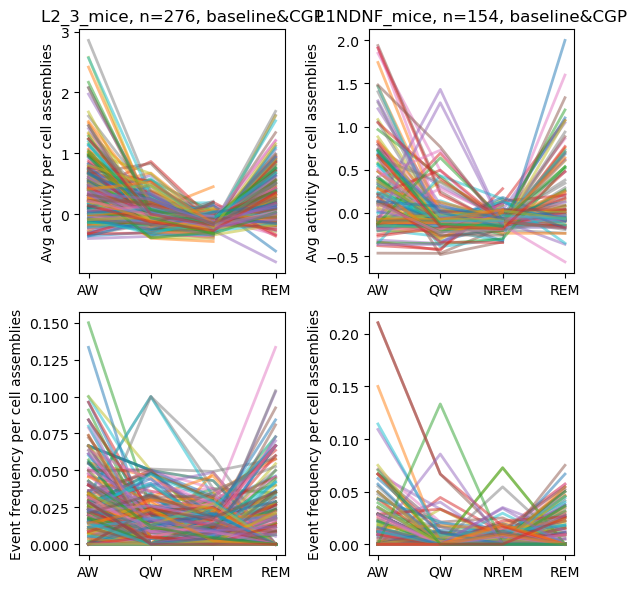

In [39]:
dfilepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis/VigSt_2025-05-03_10_01_32/CellAssembly_Global.pkl"
dfilepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_CGP_analysis/VigSt_2025-05-21_15_47_42_CGP/CellAssembly_Global.pkl"

drug= 'baseline&CGP'

try :
    combined_df0 = pd.read_excel(dfilepath, index_col=0)
except:
    with open(dfilepath, 'rb') as pickle_file:
        combined_df0 = pickle.load(pickle_file)

combined_df00=combined_df0.copy()
combined_df00['Cells_in_Assembly']=combined_df00['Cells_in_Assembly'] = combined_df00['Cells_in_Assembly'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
combined_df00 = combined_df00[combined_df00['Cells_in_Assembly'].apply(len) == combined_df00['Assembly_size']]
try :
    combined_df00.to_excel(dfilepath)
except:
    with open(dfilepath, 'wb') as pickle_file:
        pickle.dump(combined_df00, pickle_file)

NrSubtype='L2_3_mice' # L1NDNF_mice OR L2_3_mice
combined_df= combined_df00[combined_df00['NeuronType']==NrSubtype]
#combined_df=combined_df[combined_df['Drug'] == drug]

plt.figure(figsize=(6, 6))
combined_df2 = combined_df.pivot_table(index='Assembly_ID', columns=[combined_df['Substate']], values='Avg_Activity', aggfunc='mean', fill_value=None)
desired_order = ['AW','QW', 'NREM', 'REM']   
try:del combined_df2['undefined']
except: pass
try:del combined_df2['IS']
except: pass
try: combined_df2 = combined_df2[desired_order]
except: pass
plt.subplot(2,2,1)
plt.plot(combined_df2.columns, combined_df2.values.T, alpha=0.5, linewidth=2)
plt.ylabel('Avg activity per cell assemblies')
plt.title(f'{NrSubtype}, n={len(combined_df2)}, {drug}')
plt.tight_layout()

combined_df2 = combined_df.pivot_table(index='Assembly_ID', columns=[combined_df['Substate']], values='EventFreq', aggfunc='mean', fill_value=None)
try:del combined_df2['undefined']
except: pass
try:del combined_df2['IS']
except: pass
try: combined_df2 = combined_df2[desired_order]
except: pass
plt.subplot(2,2,3)
plt.plot(combined_df2.columns, combined_df2.values.T, alpha=0.5, linewidth=2)
plt.ylabel('Event frequency per cell assemblies')

NrSubtype='L1NDNF_mice' # L1NDNF_mice OR L2_3_mice
combined_df= combined_df00[combined_df00['NeuronType']==NrSubtype]
#combined_df=combined_df[combined_df['Drug'] == drug]

combined_df2 = combined_df.pivot_table(index='Assembly_ID', columns=[combined_df['Substate']], values='Avg_Activity', aggfunc='mean', fill_value=None)
try:del combined_df2['undefined']
except: pass
try:del combined_df2['IS']
except: pass
try: combined_df2 = combined_df2[desired_order]
except: pass
plt.subplot(2,2,2)
plt.plot(combined_df2.columns, combined_df2.values.T, alpha=0.5, linewidth=2)
plt.ylabel('Avg activity per cell assemblies')
plt.title(f'{NrSubtype}, n={len(combined_df2)}, {drug}')
plt.tight_layout()

combined_df2 = combined_df.pivot_table(index='Assembly_ID', columns=[combined_df['Substate']], values='EventFreq', aggfunc='mean', fill_value=None)
try:del combined_df2['undefined']
except: pass
try:del combined_df2['IS']
except: pass
try: combined_df2 = combined_df2[desired_order]
except: pass
plt.subplot(2,2,4)
plt.plot(combined_df2.columns, combined_df2.values.T, alpha=0.5, linewidth=2)
plt.ylabel('Event frequency per cell assemblies')
plt.tight_layout()
plt.savefig(f'C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure2_revised/CellAssembly_VigStActivity_{drug}.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

### Cell assembly identity

Load VigSt_Global_cluster file

In [37]:
with open(f'{Path(dfilepath).parent}/VigStates_Global_cluster.pkl', 'rb') as pickle_file:
    df_cluster = pickle.load(pickle_file)

df_cluster = df_cluster[df_cluster['NeuronType'] == 'L1NDNF_mice']
df_cluster_Drug = df_cluster.copy()

#df_cluster_Drug = df_cluster_Drug[df_cluster_Drug['Drug'] == 'baseline']

AllBaselineUnits = df_cluster_Drug['Unit_ID'].unique()
Cluster0units = df_cluster_Drug[df_cluster_Drug['ClusterHDBSCAN'] == 0]['Unit_ID'].unique()
Cluster1units = df_cluster_Drug[df_cluster_Drug['ClusterHDBSCAN'] == 1]['Unit_ID'].unique()
Cluster2units = df_cluster_Drug[df_cluster_Drug['ClusterHDBSCAN'] == 2]['Unit_ID'].unique()

Identify Cell assembly Cluster ID and test proportion


Assembly Cluster ID Distribution Test
        ID   Obs    Mean     Std      Z  p-value
     mixte    90  106.30    4.05  -4.03   0.0002
       0.0    34   22.91    3.85   2.88   0.0044
       2.0    30   24.21    3.89   1.49   0.1530


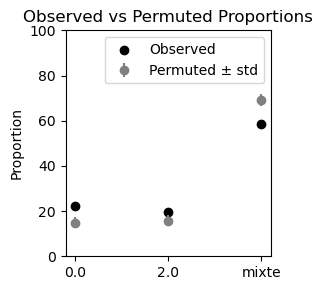

In [40]:
# --- Setup: Individuals and clusters
new_df2 = combined_df.drop_duplicates(subset='Assembly_ID', keep='first')
new_df2 = new_df2[new_df2['Cells_in_Assembly'].apply(len) == new_df2['Assembly_size']]
groups = new_df2['Cells_in_Assembly'].tolist()
df_unique = df_cluster_Drug.drop_duplicates(subset='Unit_ID', keep='first')
df_unique = df_unique.dropna(subset=['ClusterHDBSCAN'])
ids=df_unique['Unit_ID'].tolist()
id_to_cluster = dict(zip(df_unique['Unit_ID'], np.floor(df_unique['ClusterHDBSCAN']).astype(str)))
cluster_labels = ['0.0']*len(Cluster0units) + ['1.0']*len(Cluster1units) + ['2.0']*len(Cluster2units)
#cluster_labels = new_df2_c['Assembly_Cluster_ID'].tolist()

def classify_groups(groups, id_to_cluster):
    labels = []
    for group in groups:
        clusters = [id_to_cluster.get(i, np.nan) for i in group]
        if len(clusters) >= 1:
            count = Counter(clusters)
            top, n_top = count.most_common(1)[0]
            top_clusters = [k for k, v in count.items() if v == n_top]        
            # If there are multiple top clusters or the majority is less than 50%, label as "mixte"
            if len(top_clusters) == 1 and (n_top / len(group) * 100) > 50 and not pd.isna(top):
                labels.append(top)
            else:
                labels.append("mixte")  
        else:
            labels.append("mixte")    
    return labels

# --- Observed classification
observed_labels = classify_groups(groups, id_to_cluster)
observed_counts = Counter(observed_labels)
new_df2['Assembly_Cluster_ID']= observed_labels

# --- Permutation test
n_perms = 5000
null_dists = defaultdict(list)

for _ in range(n_perms):
    # Shuffle cluster labels across individuals
    shuffled_clusters = dict(zip(ids, random.sample(cluster_labels, len(cluster_labels))))
    shuffled_labels = classify_groups(groups, shuffled_clusters)
    counts = Counter(shuffled_labels)
    for label in observed_counts:
        null_dists[label].append(counts.get(label, 0))

# --- Z-scores and p-values
results = []
for label in observed_counts:
    obs = observed_counts[label]
    null = null_dists[label]
    mean = np.mean(null)
    std = np.std(null)
    z = (obs - mean) / std if std > 0 else 0
    # Two-tailed p-value
    p = (np.sum(np.abs(np.array(null) - mean) >= abs(obs - mean)) + 1) / (n_perms + 1)
    results.append((label, obs, mean, std, z, p))

# --- Output
print("\nAssembly Cluster ID Distribution Test")
print(f"{'ID':>10} {'Obs':>5} {'Mean':>7} {'Std':>7} {'Z':>6} {'p-value':>8}")
for label, obs, mean, std, z, p in sorted(results, key=lambda x: x[-1]):
    print(f"{label:>10} {obs:5} {mean:7.2f} {std:7.2f} {z:6.2f} {p:8.4f}")


df = pd.DataFrame(results, columns=["Cell_Assembly_ID", "Obs", "PermMean", "Std", "Z", "p"])
df['Obs_prop'] = df['Obs'] / df['Obs'].sum() *100
df['Perm_prop'] = df['PermMean'] / df['PermMean'].sum() *100
df["Perm_std"] = df["Std"] / df["PermMean"].sum() *100

df = df.sort_values("Cell_Assembly_ID")  # or use a custom order
plt.figure(figsize=(3, 3))
plt.errorbar(df["Cell_Assembly_ID"], df["Perm_prop"], yerr=df["Perm_std"], fmt='o', color='gray', label='Permuted ± std')
plt.scatter(df["Cell_Assembly_ID"], df["Obs_prop"], color='black', label='Observed')
plt.ylabel("Proportion")
plt.ylim(0, 100)
plt.title("Observed vs Permuted Proportions")
plt.legend()
plt.tight_layout()
plt.savefig(f'C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure2_revised/CellAssembly_Proportion_permvsreal_{drug}.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

Save cell assembly ID 

In [41]:
merged = pd.merge(combined_df0, new_df2[['Assembly_ID', 'Assembly_Cluster_ID']], on='Assembly_ID', how='outer')
merged.to_excel(f'{Path(dfilepath).parent}/CellAssembly_Global_cluster_ID.xlsx')

Activity of cell assemblies per ID

In [ ]:
merged = merged[merged['Substate'] != 'IS']
merged = merged[merged['Substate'] != 'undefined']
combined_df2 = merged.pivot_table(index='Assembly_ID', columns=[merged['Assembly_Cluster_ID'], merged['Substate']], values='Avg_Activity', aggfunc='mean', fill_value=None)
custom_order = ['AW', 'QW', 'NREM', 'REM']
sort_key = {val: i for i, val in enumerate(custom_order)}
sorted_cols = sorted(combined_df2.columns, key=lambda x: (x[0], sort_key.get(x[1], float('inf'))))
combined_df2 = combined_df2[sorted_cols]

plt.figure(figsize=(7, 3))
for idx, row in combined_df2.iterrows():
    plt.plot(row.values, label=f'{idx}', alpha=0.5, linewidth=2)  # `idx` is the MultiIndex for each row
plt.ylabel('Avg activity per cell assemblies')
plt.tight_layout()
plt.xticks(ticks= np.arange(len(combined_df2.columns.get_level_values(1))),  labels=combined_df2.columns.get_level_values(1)) 
plt.title('Cluster0                Cluster1                Cluster2                   Mixte')


combined_df2 = merged.pivot_table(index='Assembly_ID', columns=[merged['Assembly_Cluster_ID'], merged['Substate']], values='EventFreq', aggfunc='mean', fill_value=None)
custom_order = ['AW', 'QW', 'NREM', 'REM']
sort_key = {val: i for i, val in enumerate(custom_order)}
sorted_cols = sorted(combined_df2.columns, key=lambda x: (x[0], sort_key.get(x[1], float('inf'))))
combined_df2 = combined_df2[sorted_cols]

plt.figure(figsize=(7, 3))
for idx, row in combined_df2.iterrows():
    plt.plot(row.values, label=f'{idx}', alpha=0.5, linewidth=2)  # `idx` is the MultiIndex for each row
plt.ylabel('Event frequency per cell assemblies')
plt.tight_layout()
plt.xticks(ticks= np.arange(len(combined_df2.columns.get_level_values(1))),  labels=combined_df2.columns.get_level_values(1)) 
plt.title('Cluster0                Cluster1                Cluster2                   Mixte')

plt.show()

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure2_revised/{NrSubtype}_.svg", format='svg')

### Cell assemblies activity around oscillation

In [ ]:
dir = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/"
DrugExperiment=0
all_expe_types=['baseline', 'preCGP', 'postCGP'] if DrugExperiment else ['baseline', 'preCGP']
AHmethod=0

CA_PFC_L2_3_mice=pd.DataFrame()
CA_PFC_L2_3_mice_n=pd.DataFrame()
CA_PFC_L1NDNF_mice=pd.DataFrame()
CA_PFC_L1NDNF_mice_n=pd.DataFrame()
CA_PFC_L1NDNF_mice_m=pd.DataFrame()
CA_PFC_L1NDNF_mice_0=pd.DataFrame()
CA_PFC_L1NDNF_mice_1=pd.DataFrame()
CA_PFC_L1NDNF_mice_2=pd.DataFrame()

CA_S1_L2_3_mice=pd.DataFrame()
CA_S1_L2_3_mice_n=pd.DataFrame()
CA_S1_L1NDNF_mice=pd.DataFrame()
CA_S1_L1NDNF_mice_n=pd.DataFrame()
CA_S1_L1NDNF_mice_m=pd.DataFrame()
CA_S1_L1NDNF_mice_0=pd.DataFrame()
CA_S1_L1NDNF_mice_1=pd.DataFrame()
CA_S1_L1NDNF_mice_2=pd.DataFrame()

CA_S1PFC_L2_3_mice=pd.DataFrame()
CA_S1PFC_L2_3_mice_n=pd.DataFrame()
CA_S1PFC_L1NDNF_mice=pd.DataFrame()
CA_S1PFC_L1NDNF_mice_n=pd.DataFrame()
CA_S1PFC_L1NDNF_mice_m=pd.DataFrame()
CA_S1PFC_L1NDNF_mice_0=pd.DataFrame()
CA_S1PFC_L1NDNF_mice_1=pd.DataFrame()
CA_S1PFC_L1NDNF_mice_2=pd.DataFrame()

CA_SWR_L2_3_mice=pd.DataFrame()
CA_SWR_L2_3_mice_n=pd.DataFrame()
CA_SWR_L1NDNF_mice=pd.DataFrame()
CA_SWR_L1NDNF_mice_n=pd.DataFrame()
CA_SWR_L1NDNF_mice_m=pd.DataFrame()
CA_SWR_L1NDNF_mice_0=pd.DataFrame()
CA_SWR_L1NDNF_mice_1=pd.DataFrame()
CA_SWR_L1NDNF_mice_2=pd.DataFrame()

window = [-5, 5]  # from -10s to +10s around each event
bin_width = 0.1
bins = np.arange(window[0], window[1] + bin_width, bin_width)

dfilepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis/VigSt_2025-05-03_10_01_32/CellAssembly_Global_cluster_ID.xlsx"
try :
    cellassemblydf0 = pd.read_excel(dfilepath, index_col=0)
except:
    with open(dfilepath, 'rb') as pickle_file:
        cellassemblydf0 = pickle.load(pickle_file)

for dpath in Path(dir).glob('**/mappingsAB.pkl'):
    
    mappfile = open(dpath.parents[0]/ f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mappfile)
    mapping_sess = mapping['session']   

    mice = dpath.parents[0].parts[-1]
    NeuronType = dpath.parents[1].parts[-1]
    
    subsessions = []
    dict_S1PFCprop = {}
    dict_Spindleprop = {}
    dict_Path={}

    minian_folders = [f for f in dpath.parents[0].rglob('minian') if f.is_dir()]

    for minianpath in minian_folders: # for each minian folders found in this mouse

        if any(p in all_expe_types for p in minianpath.parts): # have to be to the expe_types
                        
            session=minianpath.parents[0].name if len(minianpath.parts)==12 else minianpath.parents[1].name.split("_")[-1]
            session_path=minianpath.parents[2] if len(minianpath.parts)==12 else minianpath.parents[1]
            expe_type=minianpath.parents[3].name if len(minianpath.parts)==12 else minianpath.parents[2].name
            
            session_date= minianpath.parents[2].name.split("_")[0] if len(minianpath.parts)==12 else minianpath.parents[1].name.split("_")[0]
            session_time= minianpath.parents[2].name.split("_")[1] if len(minianpath.parts)==12 else minianpath.parents[1].name.split("_")[1]

            drug='CGP' if expe_type == 'postCGP' else 'baseline'
            dict_Path[session] = session_path
            
            SWRlist= pd.read_csv(session_path / f'OpenEphys/SWRproperties.csv' ) if AHmethod else pd.read_csv(session_path / f'OpenEphys/SWR_detection.csv' ) 
            SWRlist['toKeep'] = 'True' # SWRlist['toKeep'].astype(str)
            SWRprop = SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]
            
            startSWRlist=SWRprop["start time"]/1000
            merged = cellassemblydf0.groupby(['Mice', 'Session_Date','Session_Time', 'Assembly_ID', 'Assembly_Cluster_ID'], dropna=False)['EventTime'].apply(lambda x: ', '.join(x)).reset_index() 
            for ass in merged.loc[(merged['Mice'] == mice) & (merged['Session_Date'] == session_date) & (merged['Session_Time'] == session_time)].index:
                CA_SWR_matrix=locals()[f"CA_SWR_{NeuronType}_{str(merged['Assembly_Cluster_ID'].loc[ass])[0]}"]
                CA_SWR_matrix2=locals()[f"CA_SWR_{NeuronType}"]
                COUNT=[]
                numbers = re.findall(r'[\d.]+',  merged['EventTime'].loc[ass])
                events = np.array(numbers, dtype=float)
                if len(events)>0:
                    for SWRstart in startSWRlist:                        
                        relativedistance= SWRstart-events
                        counts, _ = np.histogram(relativedistance, bins=bins)                  
                        COUNT.append(counts)                               
                    CA_SWR_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                    CA_SWR_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                else: 
                    CA_SWR_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                    CA_SWR_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                

            
            Spdllist = pd.read_csv(session_path / f'OpenEphys/Spindleproperties_S1&PFC.csv') if AHmethod else pd.read_csv(session_path / f'OpenEphys/SpindlesS1&PFC_detection.csv' ) 
            Spdllist['toKeep'] = 'True' # Spdllist['toKeep'].astype(str)
            Spdlprop  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]

            S1Spdlprop= Spdlprop[Spdlprop['CTX']=='S1']
            S1PFCSpdlprop= Spdlprop[Spdlprop['CTX']=='S1PFC']
            PFCSpdlprop= Spdlprop[Spdlprop['CTX']=='PFC']
            
            startPFClist=PFCSpdlprop["start time"]/1000
            merged = cellassemblydf0.groupby(['Mice', 'Session_Date','Session_Time', 'Assembly_ID', 'Assembly_Cluster_ID'], dropna=False)['EventTime'].apply(lambda x: ', '.join(x)).reset_index() 
            for ass in merged.loc[(merged['Mice'] == mice) & (merged['Session_Date'] == session_date) & (merged['Session_Time'] == session_time)].index:
                CA_PFC_matrix=locals()[f"CA_PFC_{NeuronType}_{str(merged['Assembly_Cluster_ID'].loc[ass])[0]}"]
                CA_PFC_matrix2=locals()[f"CA_PFC_{NeuronType}"]
                COUNT=[]
                numbers = re.findall(r'[\d.]+',  merged['EventTime'].loc[ass])
                events = np.array(numbers, dtype=float)
                if len(events)>0:
                    for spdlstart in startPFClist:                        
                        relativedistance= spdlstart-events
                        counts, _ = np.histogram(relativedistance, bins=bins)                  
                        COUNT.append(counts)                               
                    CA_PFC_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                    CA_PFC_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                else: 
                    CA_PFC_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                    CA_PFC_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                
            
            startS1list=S1Spdlprop["start time"]/1000
            merged = cellassemblydf0.groupby(['Mice', 'Session_Date','Session_Time', 'Assembly_ID', 'Assembly_Cluster_ID'], dropna=False)['EventTime'].apply(lambda x: ', '.join(x)).reset_index() 
            for ass in merged.loc[(merged['Mice'] == mice) & (merged['Session_Date'] == session_date) & (merged['Session_Time'] == session_time)].index:
                CA_S1_matrix=locals()[f"CA_S1_{NeuronType}_{str(merged['Assembly_Cluster_ID'].loc[ass])[0]}"]
                CA_S1_matrix2=locals()[f"CA_S1_{NeuronType}"]
                COUNT=[]
                numbers = re.findall(r'[\d.]+',  merged['EventTime'].loc[ass])
                events = np.array(numbers, dtype=float)
                if len(events)>0:
                    for spdlstart in startS1list:                        
                        relativedistance= spdlstart-events
                        counts, _ = np.histogram(relativedistance, bins=bins)                  
                        COUNT.append(counts)                               
                    CA_S1_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                    CA_S1_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                else: 
                    CA_S1_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                    CA_S1_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)

            
            startS1PFClist=S1PFCSpdlprop["start time"]/1000
            merged = cellassemblydf0.groupby(['Mice', 'Session_Date','Session_Time', 'Assembly_ID', 'Assembly_Cluster_ID'], dropna=False)['EventTime'].apply(lambda x: ', '.join(x)).reset_index() 
            for ass in merged.loc[(merged['Mice'] == mice) & (merged['Session_Date'] == session_date) & (merged['Session_Time'] == session_time)].index:
                CA_S1PFC_matrix=locals()[f"CA_S1PFC_{NeuronType}_{str(merged['Assembly_Cluster_ID'].loc[ass])[0]}"]
                CA_S1PFC_matrix2=locals()[f"CA_S1PFC_{NeuronType}"]
                COUNT=[]
                numbers = re.findall(r'[\d.]+',  merged['EventTime'].loc[ass])
                events = np.array(numbers, dtype=float)
                if len(events)>0:
                    for spdlstart in startS1PFClist:                        
                        relativedistance= spdlstart-events
                        counts, _ = np.histogram(relativedistance, bins=bins)                  
                        COUNT.append(counts)                               
                    CA_S1PFC_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                    CA_S1PFC_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.nanmean(COUNT, axis=0)
                else: 
                    CA_S1PFC_matrix[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)
                    CA_S1PFC_matrix2[merged['Assembly_ID'].loc[ass]+ '_' + str(merged['Assembly_Cluster_ID'].loc[ass])[0]]=np.zeros(len(bins)-1)

In [ ]:
CA_matrix_all = ['CA_S1PFC_L2_3_mice', 'CA_S1PFC_L1NDNF_mice', 'CA_S1_L2_3_mice', 'CA_S1_L1NDNF_mice', 'CA_PFC_L2_3_mice', 'CA_PFC_L1NDNF_mice', 'CA_SWR_L2_3_mice', 'CA_SWR_L1NDNF_mice']#, 'CA_S1PFC_L1NDNF_mice_n', 'CA_S1PFC_L1NDNF_mice_m',                      'CA_S1PFC_L1NDNF_mice_0', 'CA_S1PFC_L1NDNF_mice_1', 'CA_S1PFC_L1NDNF_mice_2']
label_colors = {    'n': 'white',    'm': 'grey',    '0': 'blue',     '1': 'cyan',     '2': 'green'}

plt.close()
for CA_SWR_matrix_name in CA_matrix_all: 
    CA_SWR_matrix= locals()[CA_SWR_matrix_name]
    CA_SWR_matrix_n = CA_SWR_matrix/ CA_SWR_matrix.max() 
    CA_SWR_matrix_n = CA_SWR_matrix_n.replace(np.nan, 0)
    max_row_pos = CA_SWR_matrix_n.values.argmax(axis=0)
    col_sums = CA_SWR_matrix_n.sum()
    col_info = pd.DataFrame({'col': CA_SWR_matrix_n.columns,'max_pos': max_row_pos,'sum': col_sums.values})
    col_info_sorted = col_info.sort_values(by=['max_pos', 'sum'])
    CA_SWR_matrix_s = CA_SWR_matrix_n[col_info_sorted['col'].values]
    CA_SWR_matrix_s = CA_SWR_matrix_s.loc[:, (CA_SWR_matrix_s != 0).any(axis=0)]
    df= CA_SWR_matrix_s.T

    # Row label to color index mapping
    row_labels = df.index.str[-1]
    color_codes = [list(label_colors).index(lbl) for lbl in row_labels]
    color_array = np.array(color_codes).reshape(-1, 1)
    cmap = ListedColormap([label_colors[k] for k in label_colors])
    fig = plt.figure(figsize=(3, 3))
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[3, 2],   width_ratios=[0.5, 10], hspace=0.3, wspace=0.05 )
    ax_ann = fig.add_subplot(gs[0, 0])
    sns.heatmap(color_array, ax=ax_ann, cmap=cmap, cbar=False)
    ax_ann.set_xticks([])
    ax_ann.set_yticks([])
    ax_ann.tick_params(left=False, right=False)
    ax_heatmap = fig.add_subplot(gs[0, 1])
    sns.heatmap(df, ax=ax_heatmap, cmap="viridis", cbar=False, cbar_kws={'location': 'top'}, yticklabels=False)
    ax_heatmap.set_yticklabels([]) 
    ax_heatmap.set_title(f"n = {len(df)}/{len(CA_SWR_matrix_n.T)}") 
    ax_ann.set_ylabel(CA_SWR_matrix_name)

    time_bins = np.linspace(window[0], window[1], len(bins)-1)
    ax_bottom = fig.add_subplot(gs[1, 1])  # span both columns
    ax_bottom.plot(time_bins, zscore(np.mean(df, axis=0)))
    ax_bottom.set_xlabel(f"Time from {CA_SWR_matrix_name.split('_')[1]} (s)")
    ax_bottom.set_xticks([])
    ax_bottom.set_xlim(window[0], window[1])
    ax_bottom.set_ylim(-2.5, 5)

    # Monte Carlo parameters
    n_permutations = 5000
    shuffled_psths = []
    for _ in range(n_permutations):
        shuffled_counts = np.apply_along_axis(np.random.permutation, 1, df)
        shuffled_psth = shuffled_counts.mean(axis=0)
        shuffled_psths.append(shuffled_psth)
    shuffled_psths = np.array(shuffled_psths)
    alpha = 0.05
    lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
    upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
    significant_bins05 = (np.mean(df, axis=0) < lower_bound) | (np.mean(df, axis=0) > upper_bound)
    ax_bottom.scatter(time_bins[significant_bins05], np.linspace(4, 4, len(time_bins))[significant_bins05], marker='_', s=5, color= 'r')
    plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure4_revised/CellAssembly_Heatmap_{CA_SWR_matrix_name.split('_')[2]}_{CA_SWR_matrix_name.split('_')[1]}.svg", format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()